### Unsupervised Data Mining with K-Means

In [1]:
#!pip install nose

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.testing import assert_frame_equal

### Dimension Reduction

Data: Delta Airline data. Delta and other major airlines have data on all of their aircrafts on their website. [e.g.](https://www.delta.com/content/www/en_US/traveling-with-us/airports-and-aircraft/Aircraft.html)

This data set has 34 columns (including the names of the aircrafts) on 44 aircrafts. It inclues both quantitative measurements such as cruising speed, accommodation and range in miles, as well as categorical data, such as whether a particular aircraft has Wi-Fi or video. These binary are assigned values of either 1 or 0, for yes or no respectively.

In [4]:
df = pd.read_csv('delta.csv', index_col='Aircraft')

In [5]:
df.head()

,Seat Width (Club),Seat Pitch (Club),Seat (Club),Seat Width (First Class),Seat Pitch (First Class),Seats (First Class),Seat Width (Business),Seat Pitch (Business),Seats (Business),Seat Width (Eco Comfort),...,Video,Power,Satellite,Flat-bed,Sleeper,Club,First Class,Business,Eco Comfort,Economy
Aircraft,,,,,,,,,,,,,,,,,,,,,
Airbus A319,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A319 VIP,19.4,44,12,19.4,40.0,28,21.0,59.0,14,0.0,...,1,0,0,0,0,1,1,1,0,0
Airbus A320,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A320 32-R,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A330-200,0.0,0,0,0.0,0.0,0,21.0,60.0,32,18.0,...,1,1,0,1,0,0,0,1,1,1


First, let's look at the attributes related to the aircraft physical characteristics:

Cruising Speed (mph)
Range (miles)
Engines
Wingspan (ft)
Tail Height (ft)
Length (ft)
These six variables are about in the middle of the data frame.

In [6]:
def plot_pairgrid(df):
    characteristics = ["Cruising Speed (mph)", "Range (miles)", "Engines",
                         "Wingspan (ft)", "Tail Height (ft)", "Length (ft)"]
    
    ax = sns.PairGrid(df[characteristics])

    ax.map_diag(plt.hist)
    
    ax.map_offdiag(plt.scatter)
    
    return ax

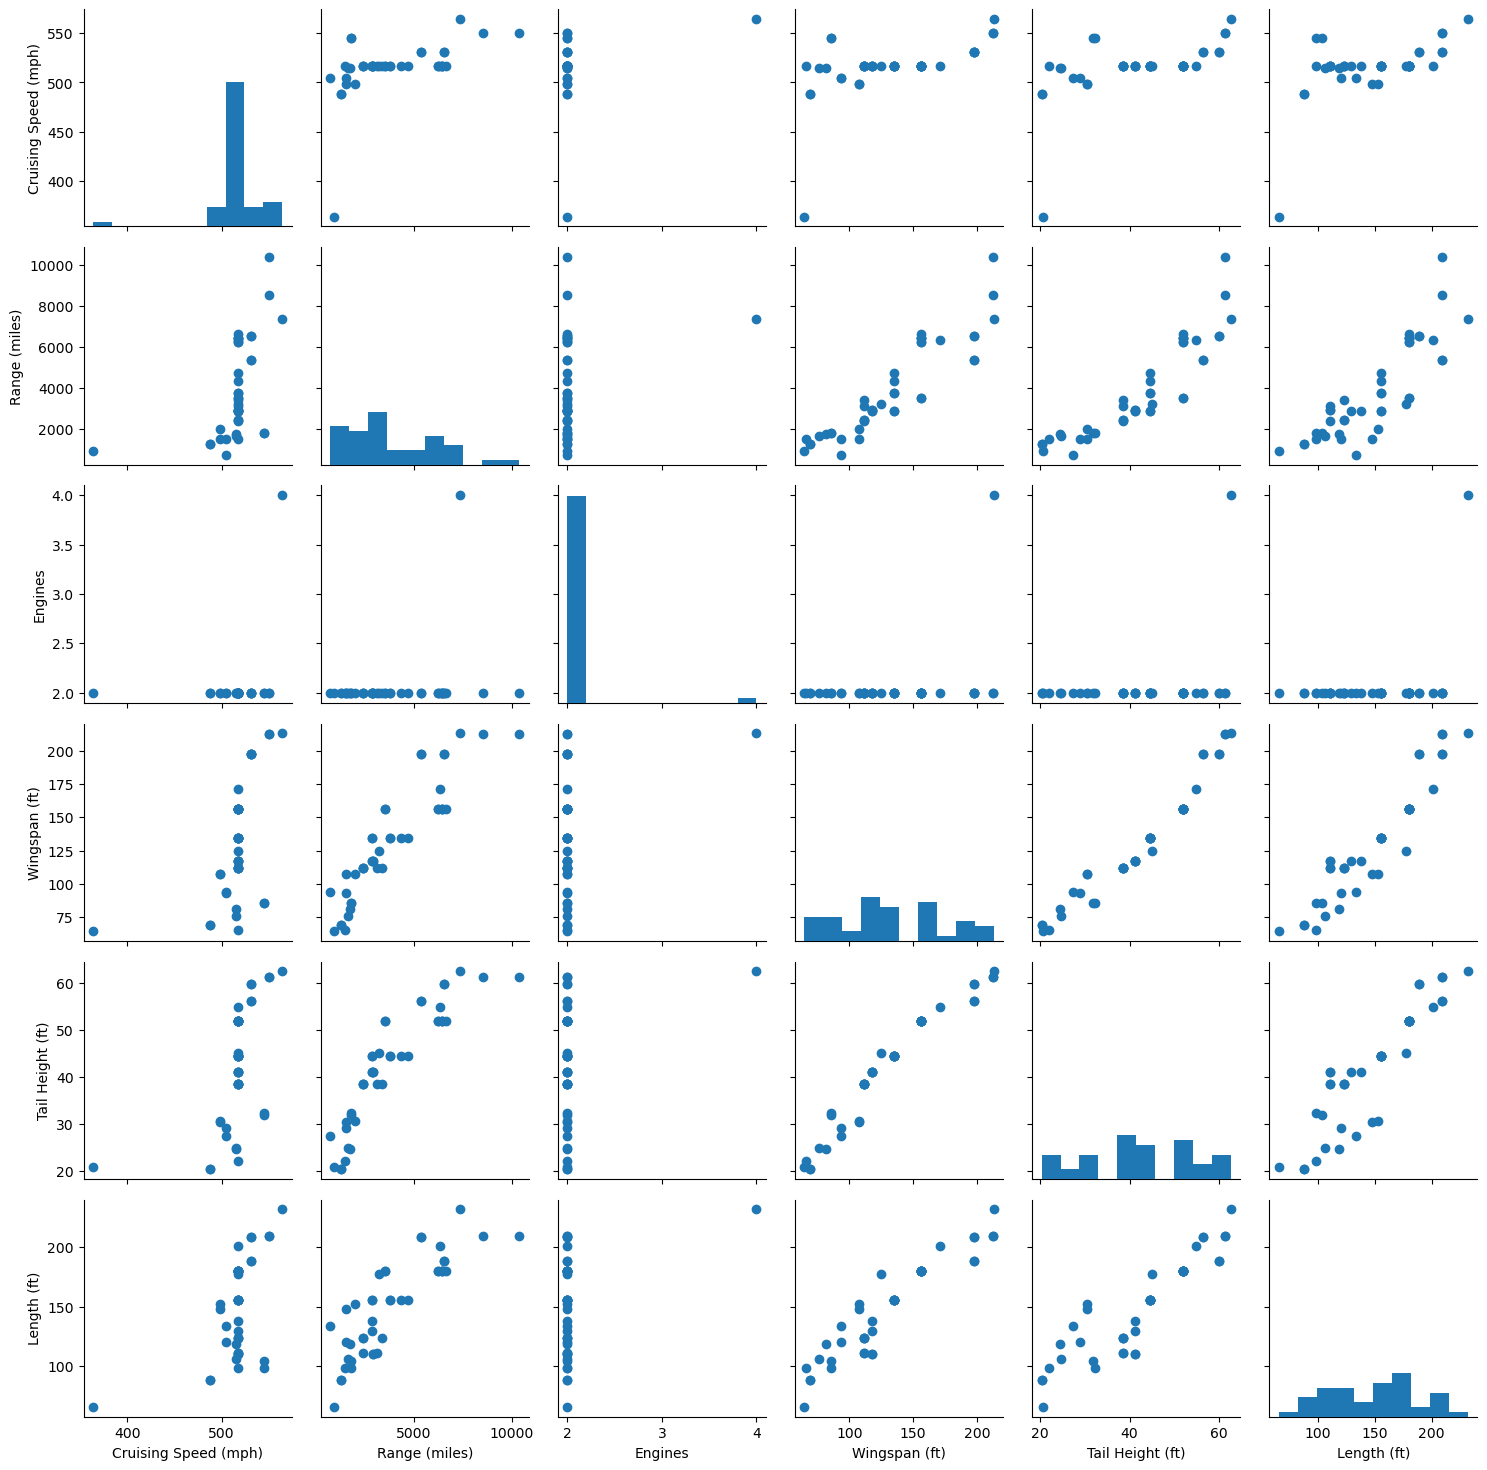

In [8]:
pg = plot_pairgrid(df)

We observe that pretty strong positive correlations between all these variables, as most of them are related to the aircraft’s overall size. Remarkably there is an almost perfectly linear relationship between wingspan and tail height.

The exception here is engines. There is one outlier which has four engines, while all the other aircraft have two. In this way the engines variable is really more like a categorical variable, but we shall as the analysis progresses that this is not really important, as there are other variables which more strongly discern the aircraft from one another than this.

In [9]:
cols = ['Cruising Speed (mph)', 'Range (miles)', 'Engines',
        'Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']

assert_is_instance(pg.fig, plt.Figure)
assert_equal(set(pg.data.columns), set(cols))

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 10)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

#### Apply preliminary PCA

In [10]:
 def fit_pca(df, n_components):
        
    pca = PCA(n_components)
    
    pca.fit(df)
    
    return pca

In [11]:
pca_naive = fit_pca(df, n_components=df.shape[1])

In [12]:
assert_is_instance(pca_naive, PCA)
assert_almost_equal(pca_naive.explained_variance_ratio_.sum(), 1.0, 3)
assert_equal(pca_naive.n_components_, df.shape[1])
assert_equal(pca_naive.whiten, False)

In [13]:
def plot_naive_variance(pca):
 
    explained_var_ratio = pca.explained_variance_ratio_
    
    
    fig, ax = plt.subplots()
    
    ax.plot(explained_var_ratio)
    
   
    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
 
    return ax

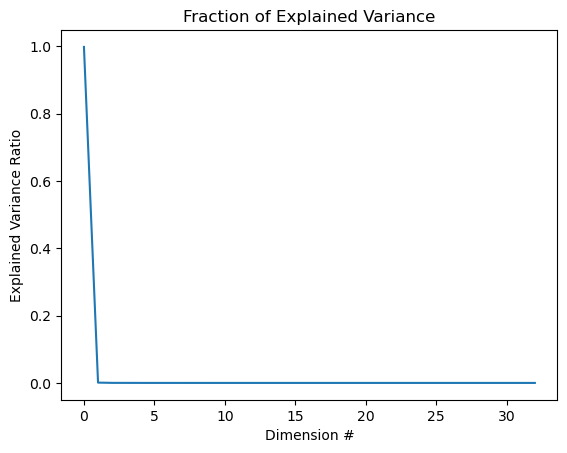

In [15]:
naive_var = plot_naive_variance(pca_naive)

In [16]:
assert_is_instance(naive_var, mpl.axes.Axes)
assert_equal(len(naive_var.lines), 1)

assert_is_not(len(naive_var.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(naive_var.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(naive_var.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

xdata, ydata = naive_var.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(df.shape[1])))
assert_array_almost_equal(ydata, pca_naive.explained_variance_ratio_)

In [17]:
abs_val = np.abs(pca_naive.components_[0])
max_pos = abs_val.argmax()
max_val = abs_val.max()

print('"{0}" accounts for {1:0.3f} % of the variance.'.format(df.columns[max_pos], max_val))

"Range (miles)" accounts for 0.999 % of the variance.


Taking this naive approach, we can see that the first principal component accounts for 99.9% of the variance in the data. (Note the y-axis is on a log scale.) Looking more closely, can we see that the first principle component is just the range in miles. This is because the scale of the different variables in the data set is quite variable.

PCA is a scale-dependent method. For example, if the range of one column is [-100, 100], while the that of another column is [-0.1, 0.1], PCA will place more weight on the feature with larger values. One way to avoid this is to standardize a data set by scaling each feature so that the individual features all look like Gausssian distributions with zero mean and unit variance. 

Therefore, we'll be normalizing the data.

In [19]:
def standardize(df):
    
    scaler = StandardScaler()
    
    scaled = scaler.fit_transform(df)
    
    return scaled

In [20]:
scaled = standardize(df)

In [23]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0 

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0]
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.]
    )

In [24]:
# we keep only 10 components
n_components = 10
pca = fit_pca(scaled, n_components=n_components)

In [25]:
def plot_scaled_variance(pca):

    explained_var_ratio = pca.explained_variance_ratio_
    
    
    fig, ax = plt.subplots()
    
    ax.plot(explained_var_ratio)
    
   
    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    

    return ax

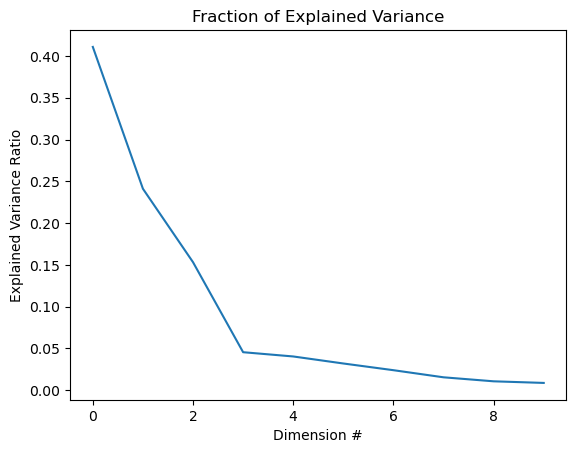

In [26]:
ax = plot_scaled_variance(pca)

In [27]:
assert_is_instance(ax, mpl.axes.Axes)
assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

xdata, ydata = ax.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(n_components)))
assert_array_almost_equal(ydata, pca.explained_variance_ratio_)

In [28]:
def reduce(pca, array):
    
    reduced = pca.transform(array)

    return reduced

In [29]:
reduced = reduce(pca, scaled)

In [30]:
assert_is_instance(reduced, np.ndarray)
assert_array_almost_equal(reduced, pca.fit_transform(scaled))

In [31]:
np.save('delta_reduced.npy', reduced)

### Clustering
Using the first 10 principal components of the Delta Airline data set created in the first step.

In [32]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

In [27]:
## Reload the the first 10 components of delta dataset
reduced = np.load('delta_reduced.npy')

## K-Means
Using default values for all parameters in KMeans() execept for n_clusters and random_state.

In [34]:
def cluster(array, random_state, n_clusters=4):
    
    model = KMeans(n_clusters = n_clusters, n_init = 10, random_state = random_state)

    clusters = model.fit_predict(array)
   
    
    return model, clusters

In [35]:
k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(1), n_clusters=5)

assert_is_instance(k_means_t, sklearn.cluster._kmeans.KMeans)
assert_is_instance(cluster_t, np.ndarray)
assert_equal(k_means_t.n_init, 10)
assert_equal(k_means_t.n_clusters, 5)
assert_equal(len(cluster_t), len(reduced))
assert_true((cluster_t < 5).all()) # n_cluster = 5 so labels should be between 0 and 5
assert_true((cluster_t >= 0).all())
labels_gold = -1. * np.ones(len(reduced), dtype=int)
mindist = np.empty(len(reduced))
mindist.fill(np.infty)
for i in range(5):
    dist = np.sum((reduced - k_means_t.cluster_centers_[i])**2., axis=1)
    labels_gold[dist < mindist] = i
    mindist = np.minimum(dist, mindist)
assert_true((mindist >= 0.0).all())
assert_true((labels_gold != -1).all())
assert_array_equal(labels_gold, cluster_t)

In [36]:
def plot_inertia(array, start=1, end=10):
    
    inertia = []
    ks = range(start, end+1)

    for k in ks:
        model = KMeans(n_clusters=k, n_init = 10, random_state=check_random_state(0))
        model.fit(array)
        inertia.append(model.inertia_)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.plot(ks, inertia)
    

    return ax

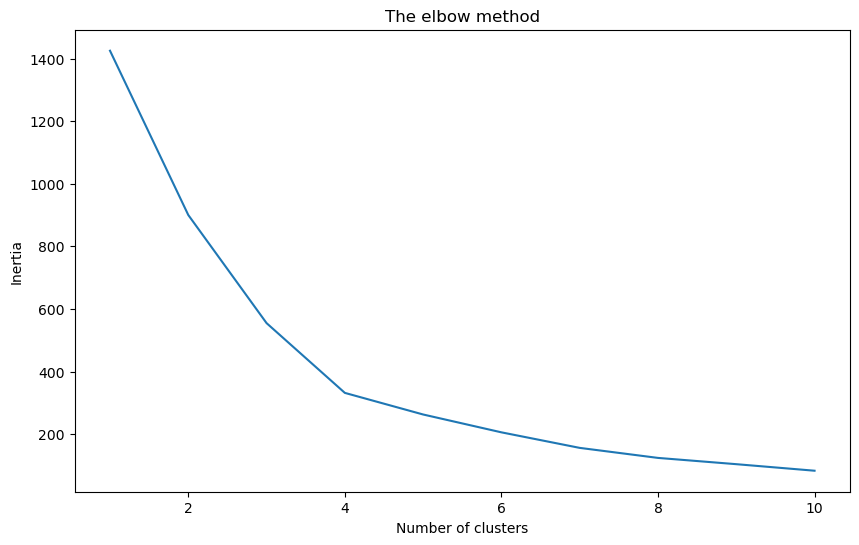

In [37]:
inertia = plot_inertia(reduced)

In [38]:
assert_is_instance(inertia, mpl.axes.Axes)
assert_true(len(inertia.lines) >= 1)

xdata, ydata = inertia.lines[0].get_xydata().T

for i in range(1, 11):
    k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(0), n_clusters=i)
    assert_array_equal(xdata[i - 1], i)
    assert_almost_equal(ydata[i - 1], k_means_t.inertia_)

assert_is_not(len(inertia.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(inertia.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(inertia.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

In [39]:
def plot_pair(reduced, clusters):
    
    df = pd.DataFrame(reduced)
    df['c'] = clusters
    subset = [0,1,2,3, 'c']
    columns = [0,1,2,3]
    
    ax = sns.PairGrid(df[subset], vars = columns, hue = 'c')
    ax = ax.map_diag(plt.hist)
    ax = ax.map_offdiag(plt.scatter)
    
    return ax

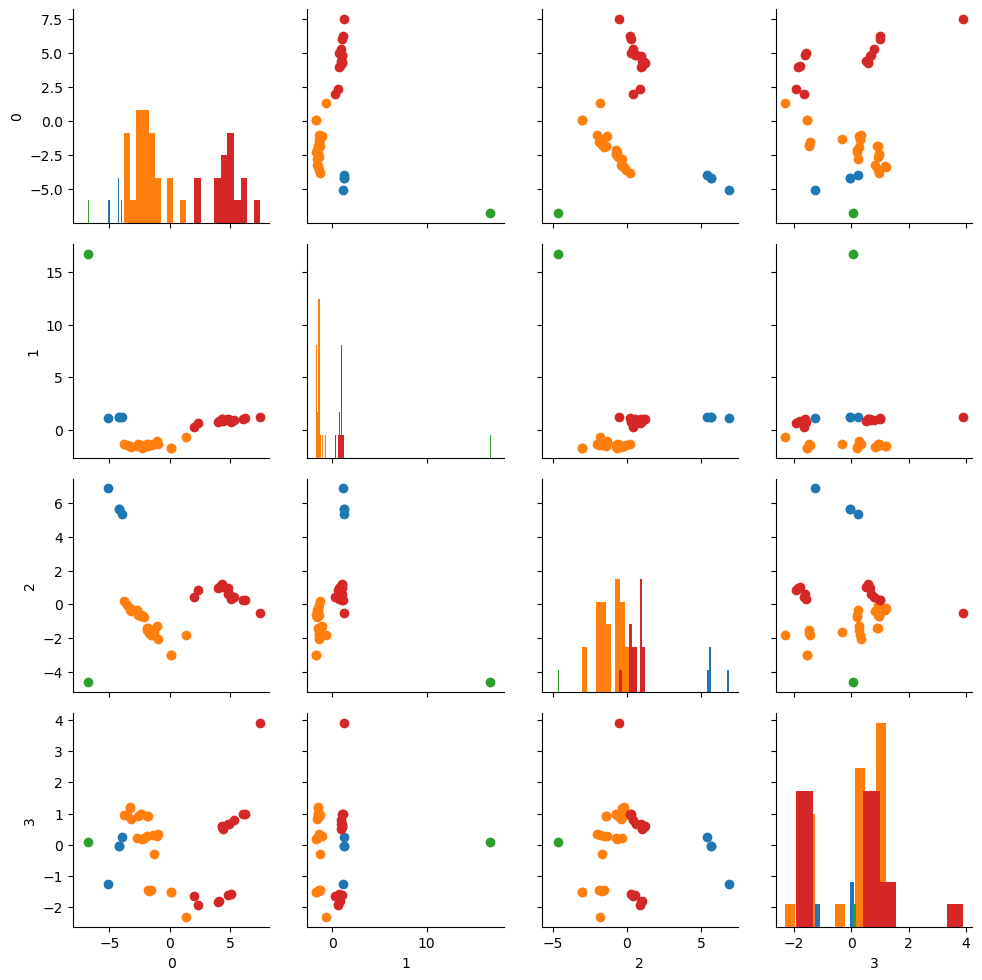

In [40]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

We observe that the one outlier is in its own cluster, there’s 3 or 4 points in the other clusters and the remainder are split into two clusters of greater size.

In [41]:
assert_is_instance(pg.fig, plt.Figure)
assert_true(len(pg.data.columns) >= 4)

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 4 * 10) # 4 clusters with 10 patches in each histogram

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_out, y_out = ax.collections[0].get_offsets().T
    x_in = reduced[clusters == 0, j] # we only check the first cluster
    y_in = reduced[clusters == 0, i]
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = reduced[clusters == 0, j]
    y_in = reduced[clusters == 0, i]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

In [51]:
df = pd.read_csv('delta.csv', index_col='Aircraft')
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean(numeric_only=True)
print(df_grouped.Accommodation)

Clusters
0     44.500000
1    153.625000
2     54.000000
3    244.733333
Name: Accommodation, dtype: float64


In [53]:
print(df_grouped['Length (ft)'])

Clusters
0     84.810750
1    137.048083
2    111.000000
3    190.538400
Name: Length (ft), dtype: float64


Cluster 3 has only one aircraft:

In [54]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


Airbus A319 VIP is not one of Delta Airline's regular fleet and is one of Airbus corporate jets.

Cluster 2 has four aircrafts.

In [55]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


These are small aircrafts and only have economy seats.

In [56]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                 First Class  Business  Eco Comfort  Economy
Aircraft                                                    
Airbus A319 VIP            1         1            0        0


In [57]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

Interesting, Cluster 1 aircrafts do not have first class seating.



In [58]:
print(df.loc[clust1.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   

In [59]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


The aircrafts in cluster 0 (except for one aircraft) have first class seating but no business class.



In [60]:
print(df.loc[clust0.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


### DBSCAN and KMeans Comparison

In [61]:
import pandas as pd
iris=pd.read_csv("/Users/bianca/Documents/U of Chicago/Classes/Data Mining/Assignment-01-2024/Week_2_Data/Iris.csv")
iris = iris[["SepalWidthCm", "PetalLengthCm"]]
iris = iris.values.astype("float32", copy=False)

### DBSCAN on Iris.csv

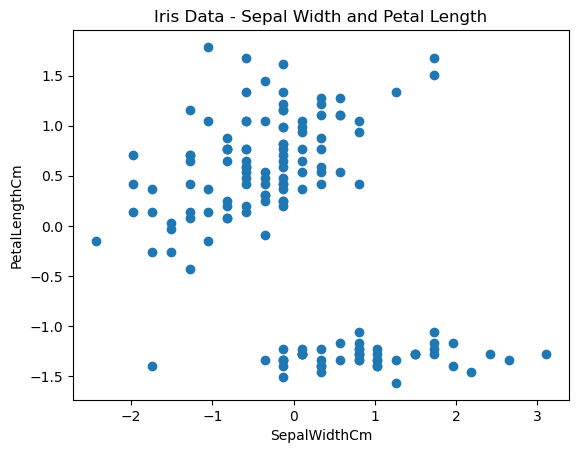

In [63]:
from sklearn.preprocessing import StandardScaler
import numpy as np
stscaler = StandardScaler().fit(iris)
iris = stscaler.transform(iris)

plt.scatter(iris[:,0], iris[:,1])
plt.xlabel("SepalWidthCm")
plt.ylabel("PetalLengthCm")
plt.title("Iris Data - Sepal Width and Petal Length")
plt.show()

In [64]:
from sklearn.cluster import DBSCAN

#changed epsilon to fit DBScan 
dbsc = DBSCAN(eps = .6, min_samples = 13).fit(iris)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

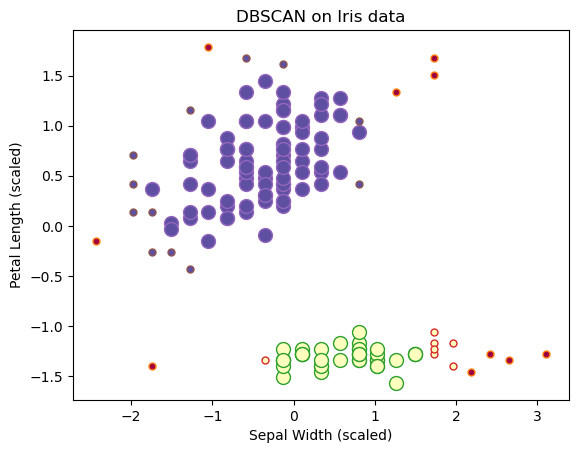

In [65]:
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = iris[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = iris[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Iris data")
plt.xlabel("Sepal Width (scaled)")
plt.ylabel("Petal Length (scaled)")
plt.show()

### K-Means on Iris.csv

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

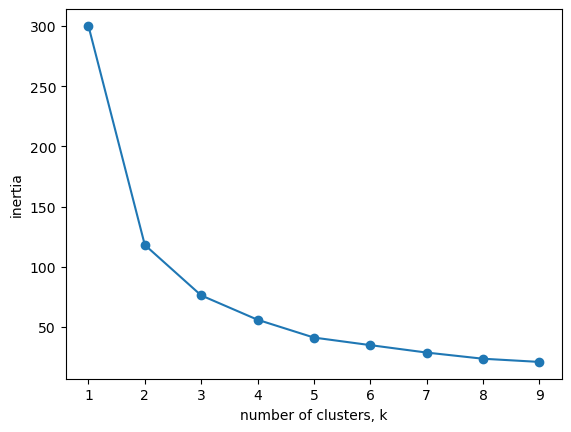

In [67]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init=10)
    
    model.fit(iris)
    
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [68]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(iris)

KMeans(n_clusters=3)

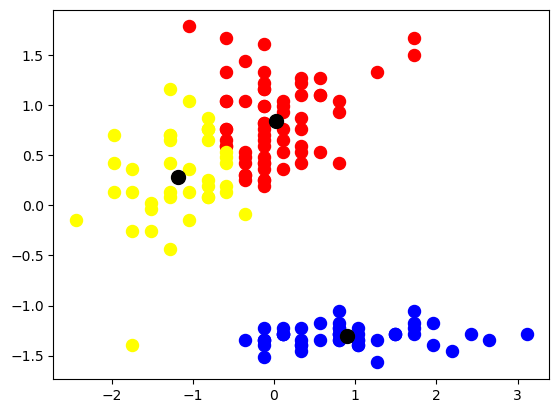

In [69]:
labels = kmeans.fit_predict(iris)

plt.scatter(iris[labels == 0, 0], iris[labels == 0, 1], s = 75, 
            c = 'blue', label = 'a')
plt.scatter(iris[labels == 1, 0], iris[labels == 1, 1], s = 75, 
            c = 'red', label = 'b')
plt.scatter(iris[labels == 2, 0], iris[labels == 2, 1], s = 75, 
            c = 'yellow', label = 'c')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'black', label = 'Centroide')
plt.show()

### Comparison between DBSCAN and K-means methods
The DBSCAN resulted in 2 clusters, while kmeans indicated the presence of another cluster, making 3 total clusters. The Iris dataset actually has 3 clusters, which means k-means is a more accurate method in this case. Since most of the Iris data shown above are close together, it's understandable that a density-based method like DBSCAN has trouble separating clusters that are close to each other. In this case, the clusters are also pretty spherical and similar in size, which is good for partitioning-based clustering method like k-means.

### DBSCAN on Reduced_Delta.npy

In [70]:
import numpy as np
reduced_delta = np.load('delta_reduced.npy')
# reduced_delta = pd.DataFrame(reduced_delta)
reduced_delta

array([[-2.65602062e+00, -1.38241098e+00, -6.04632297e-01,
         9.37261785e-01, -8.33086491e-01, -1.61945768e-01,
         1.54809554e-01, -2.62093027e-02, -2.78241107e-01,
        -2.42455888e-01],
       [-6.76662241e+00,  1.67437341e+01, -4.63409931e+00,
         8.00519882e-02, -1.73566992e-01, -1.22511528e-01,
         5.50792251e-03,  1.52931600e-01, -2.50150278e-02,
         7.03546481e-02],
       [-2.39665376e+00, -1.48769205e+00, -7.07970613e-01,
         9.69812669e-01, -7.01819052e-01,  5.67877879e-02,
         8.21780243e-02,  4.35736383e-02, -5.57340857e-01,
        -8.56469674e-02],
       [-2.39665376e+00, -1.48769205e+00, -7.07970613e-01,
         9.69812669e-01, -7.01819052e-01,  5.67877879e-02,
         8.21780243e-02,  4.35736383e-02, -5.57340857e-01,
        -8.56469674e-02],
       [ 4.86238710e+00,  9.51891957e-01,  6.19606386e-01,
         6.79015562e-01,  2.10635133e-01, -7.75235342e-01,
        -9.55583047e-01, -1.35180102e-01,  3.83776824e-02,
         1.

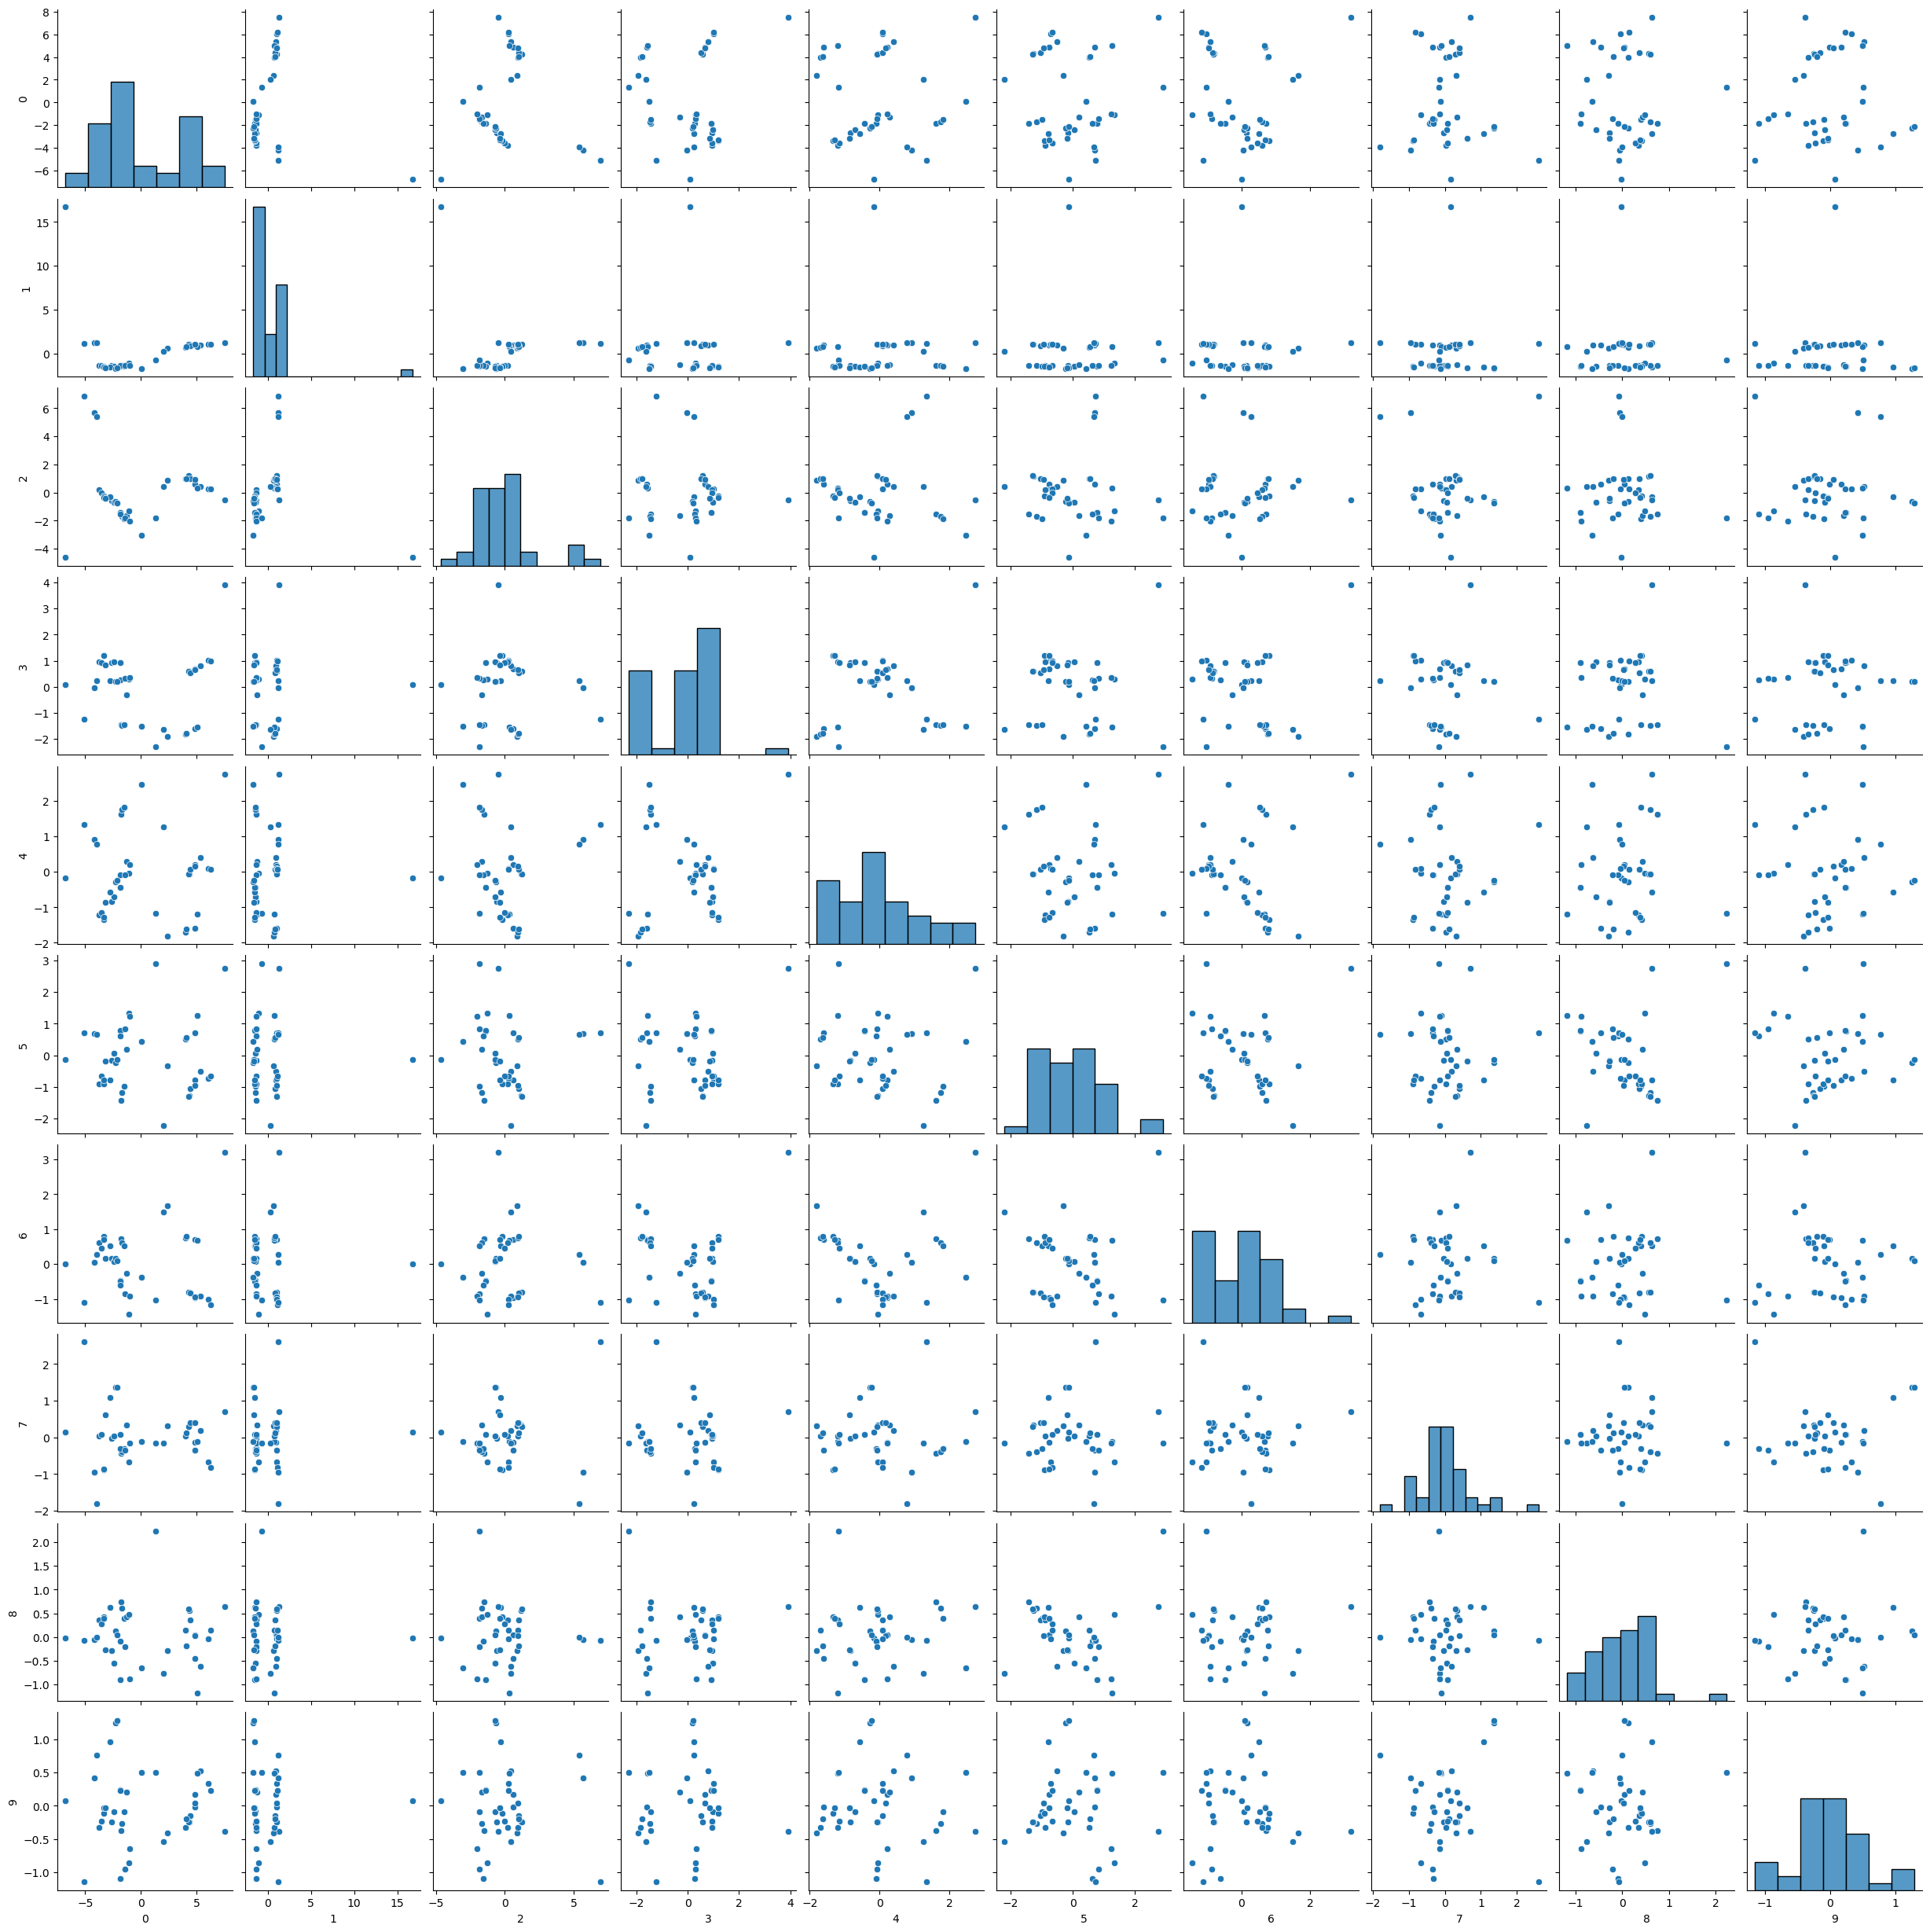

In [71]:
sns.pairplot(data=pd.DataFrame(reduced_delta))

In [72]:
dbsc = DBSCAN(eps = 2.5, min_samples = 15).fit(reduced_delta)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

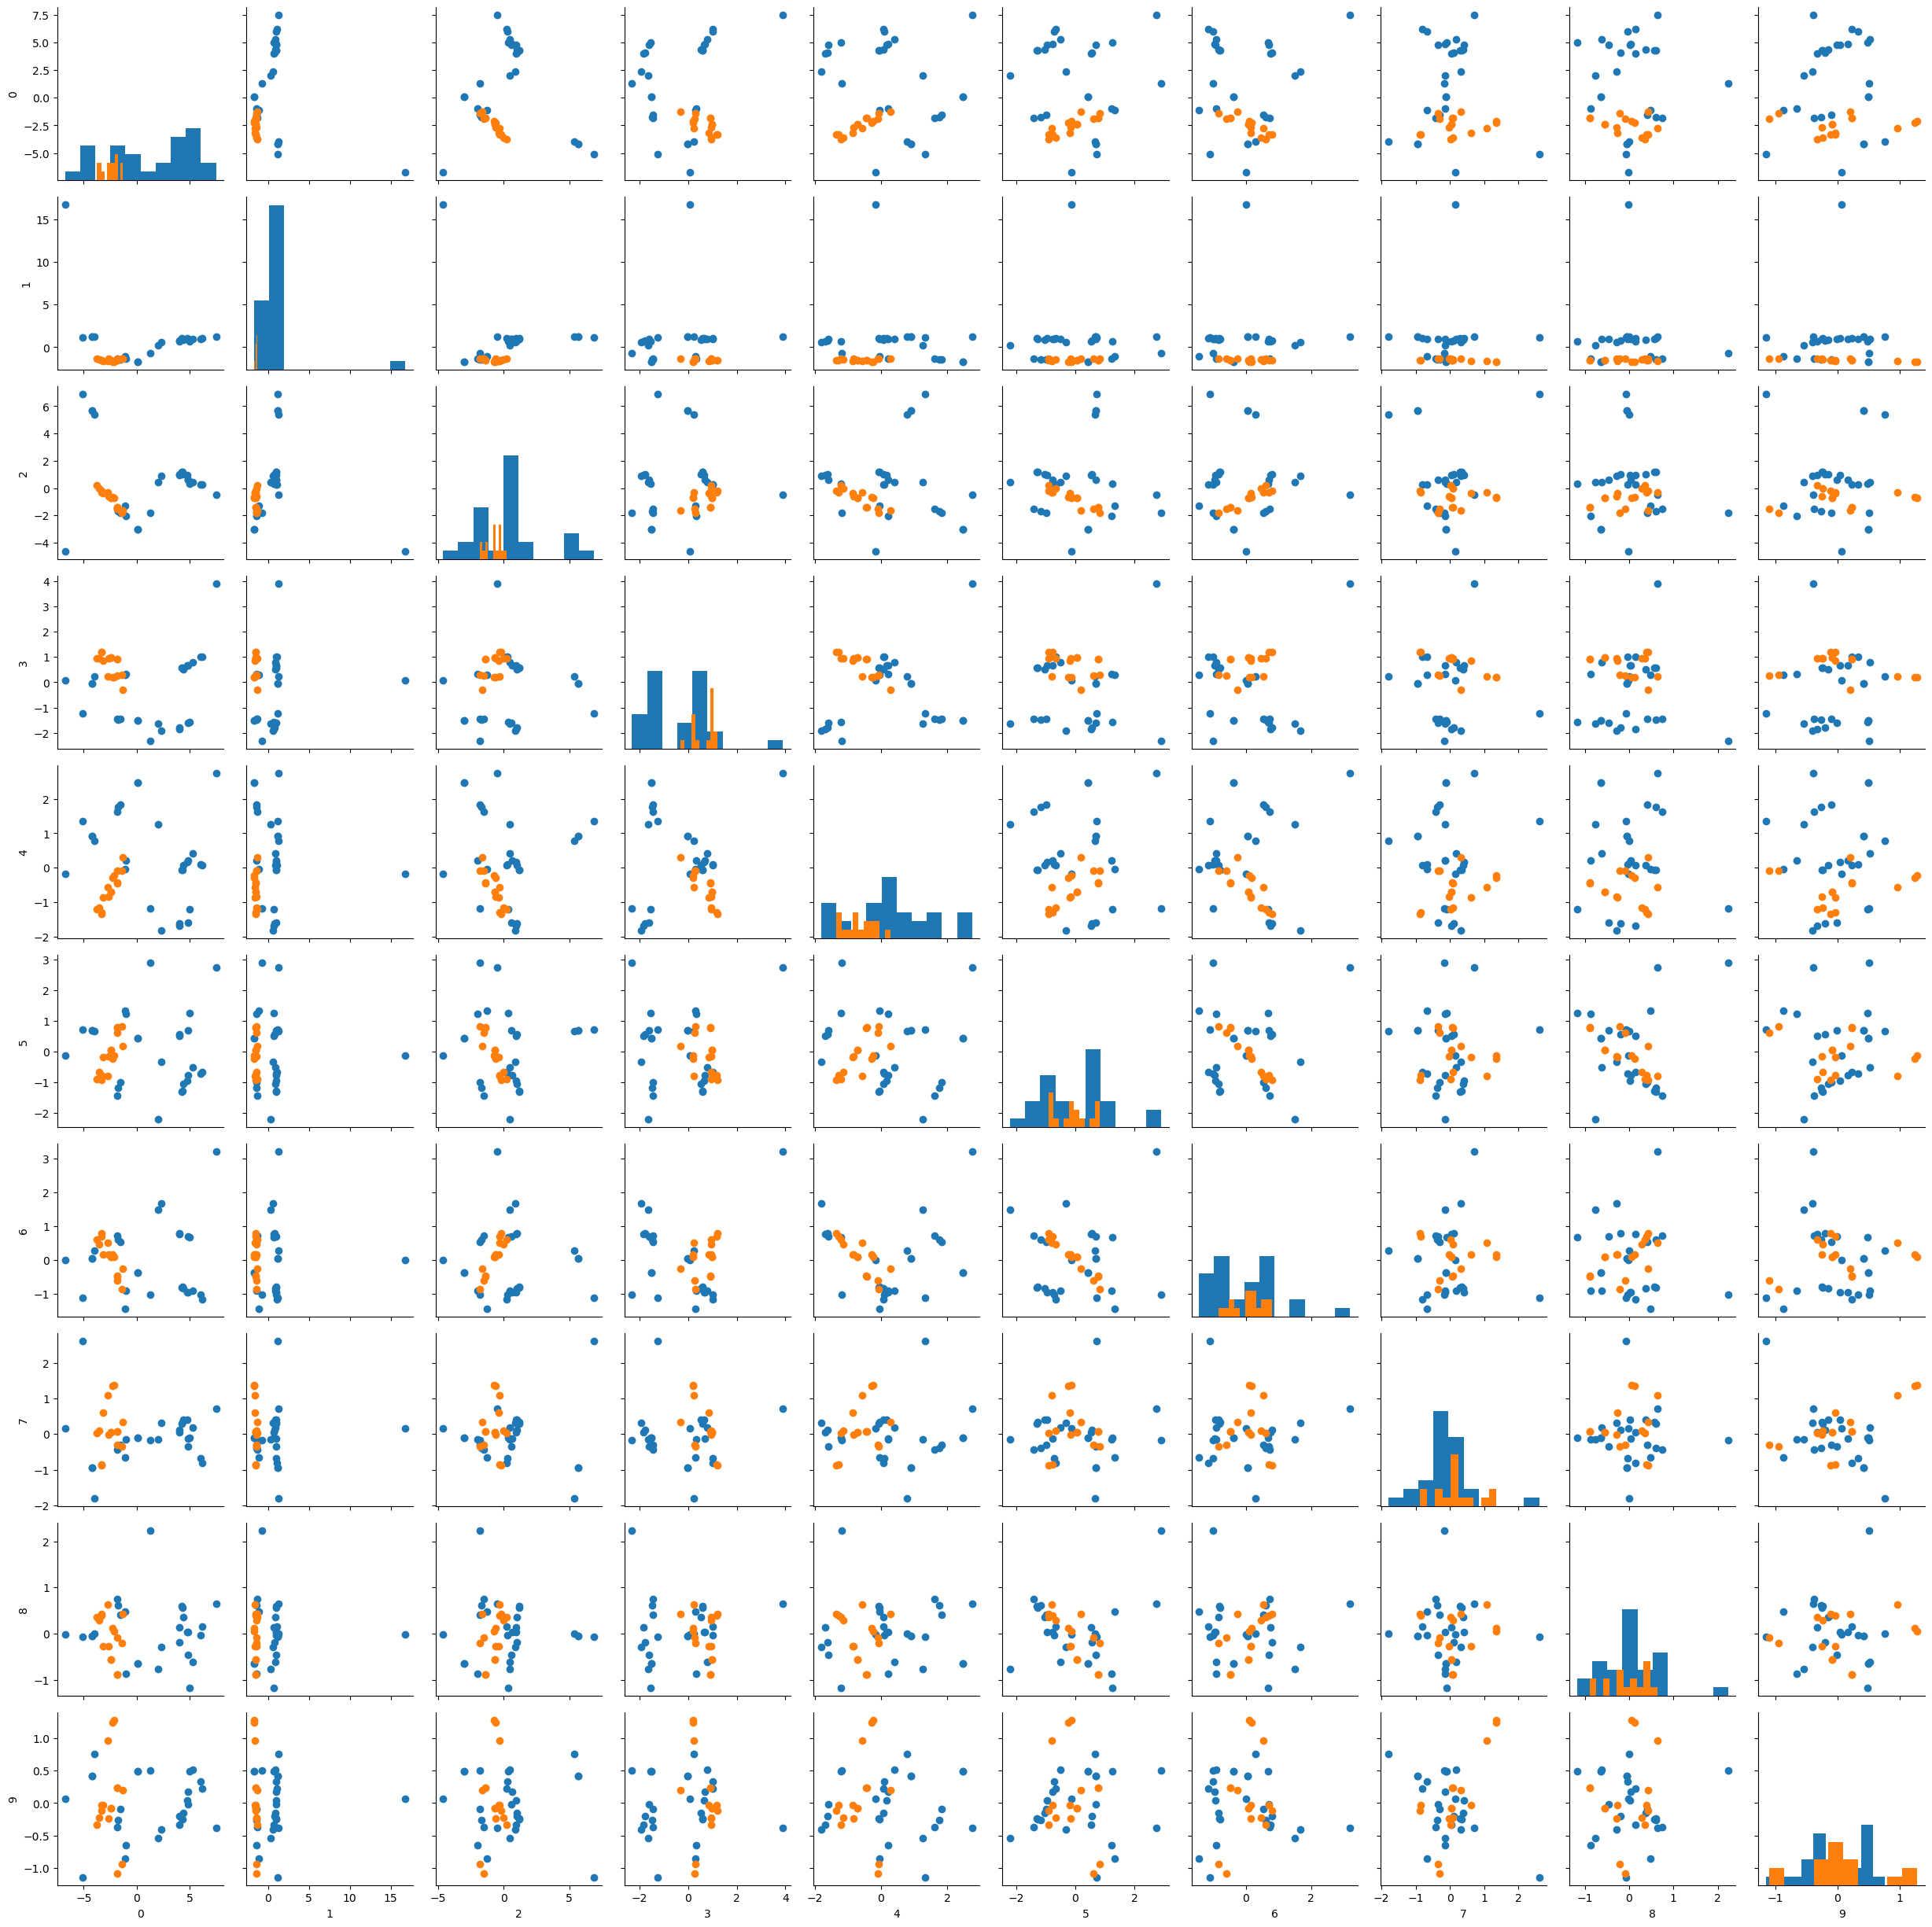

In [73]:
df = pd.DataFrame(reduced_delta)
df['c'] = labels
ax = sns.PairGrid(df, hue = 'c')
ax = ax.map_diag(plt.hist)
ax = ax.map_offdiag(plt.scatter)
ax

### K-Means on Reduced_Delta.npy

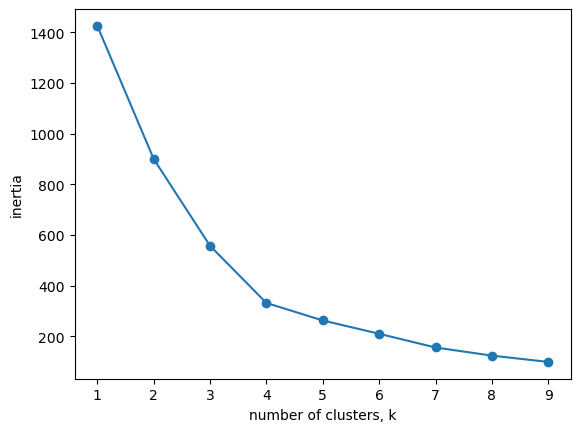

In [74]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(reduced_delta)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [75]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(reduced_delta)

KMeans(n_clusters=4)

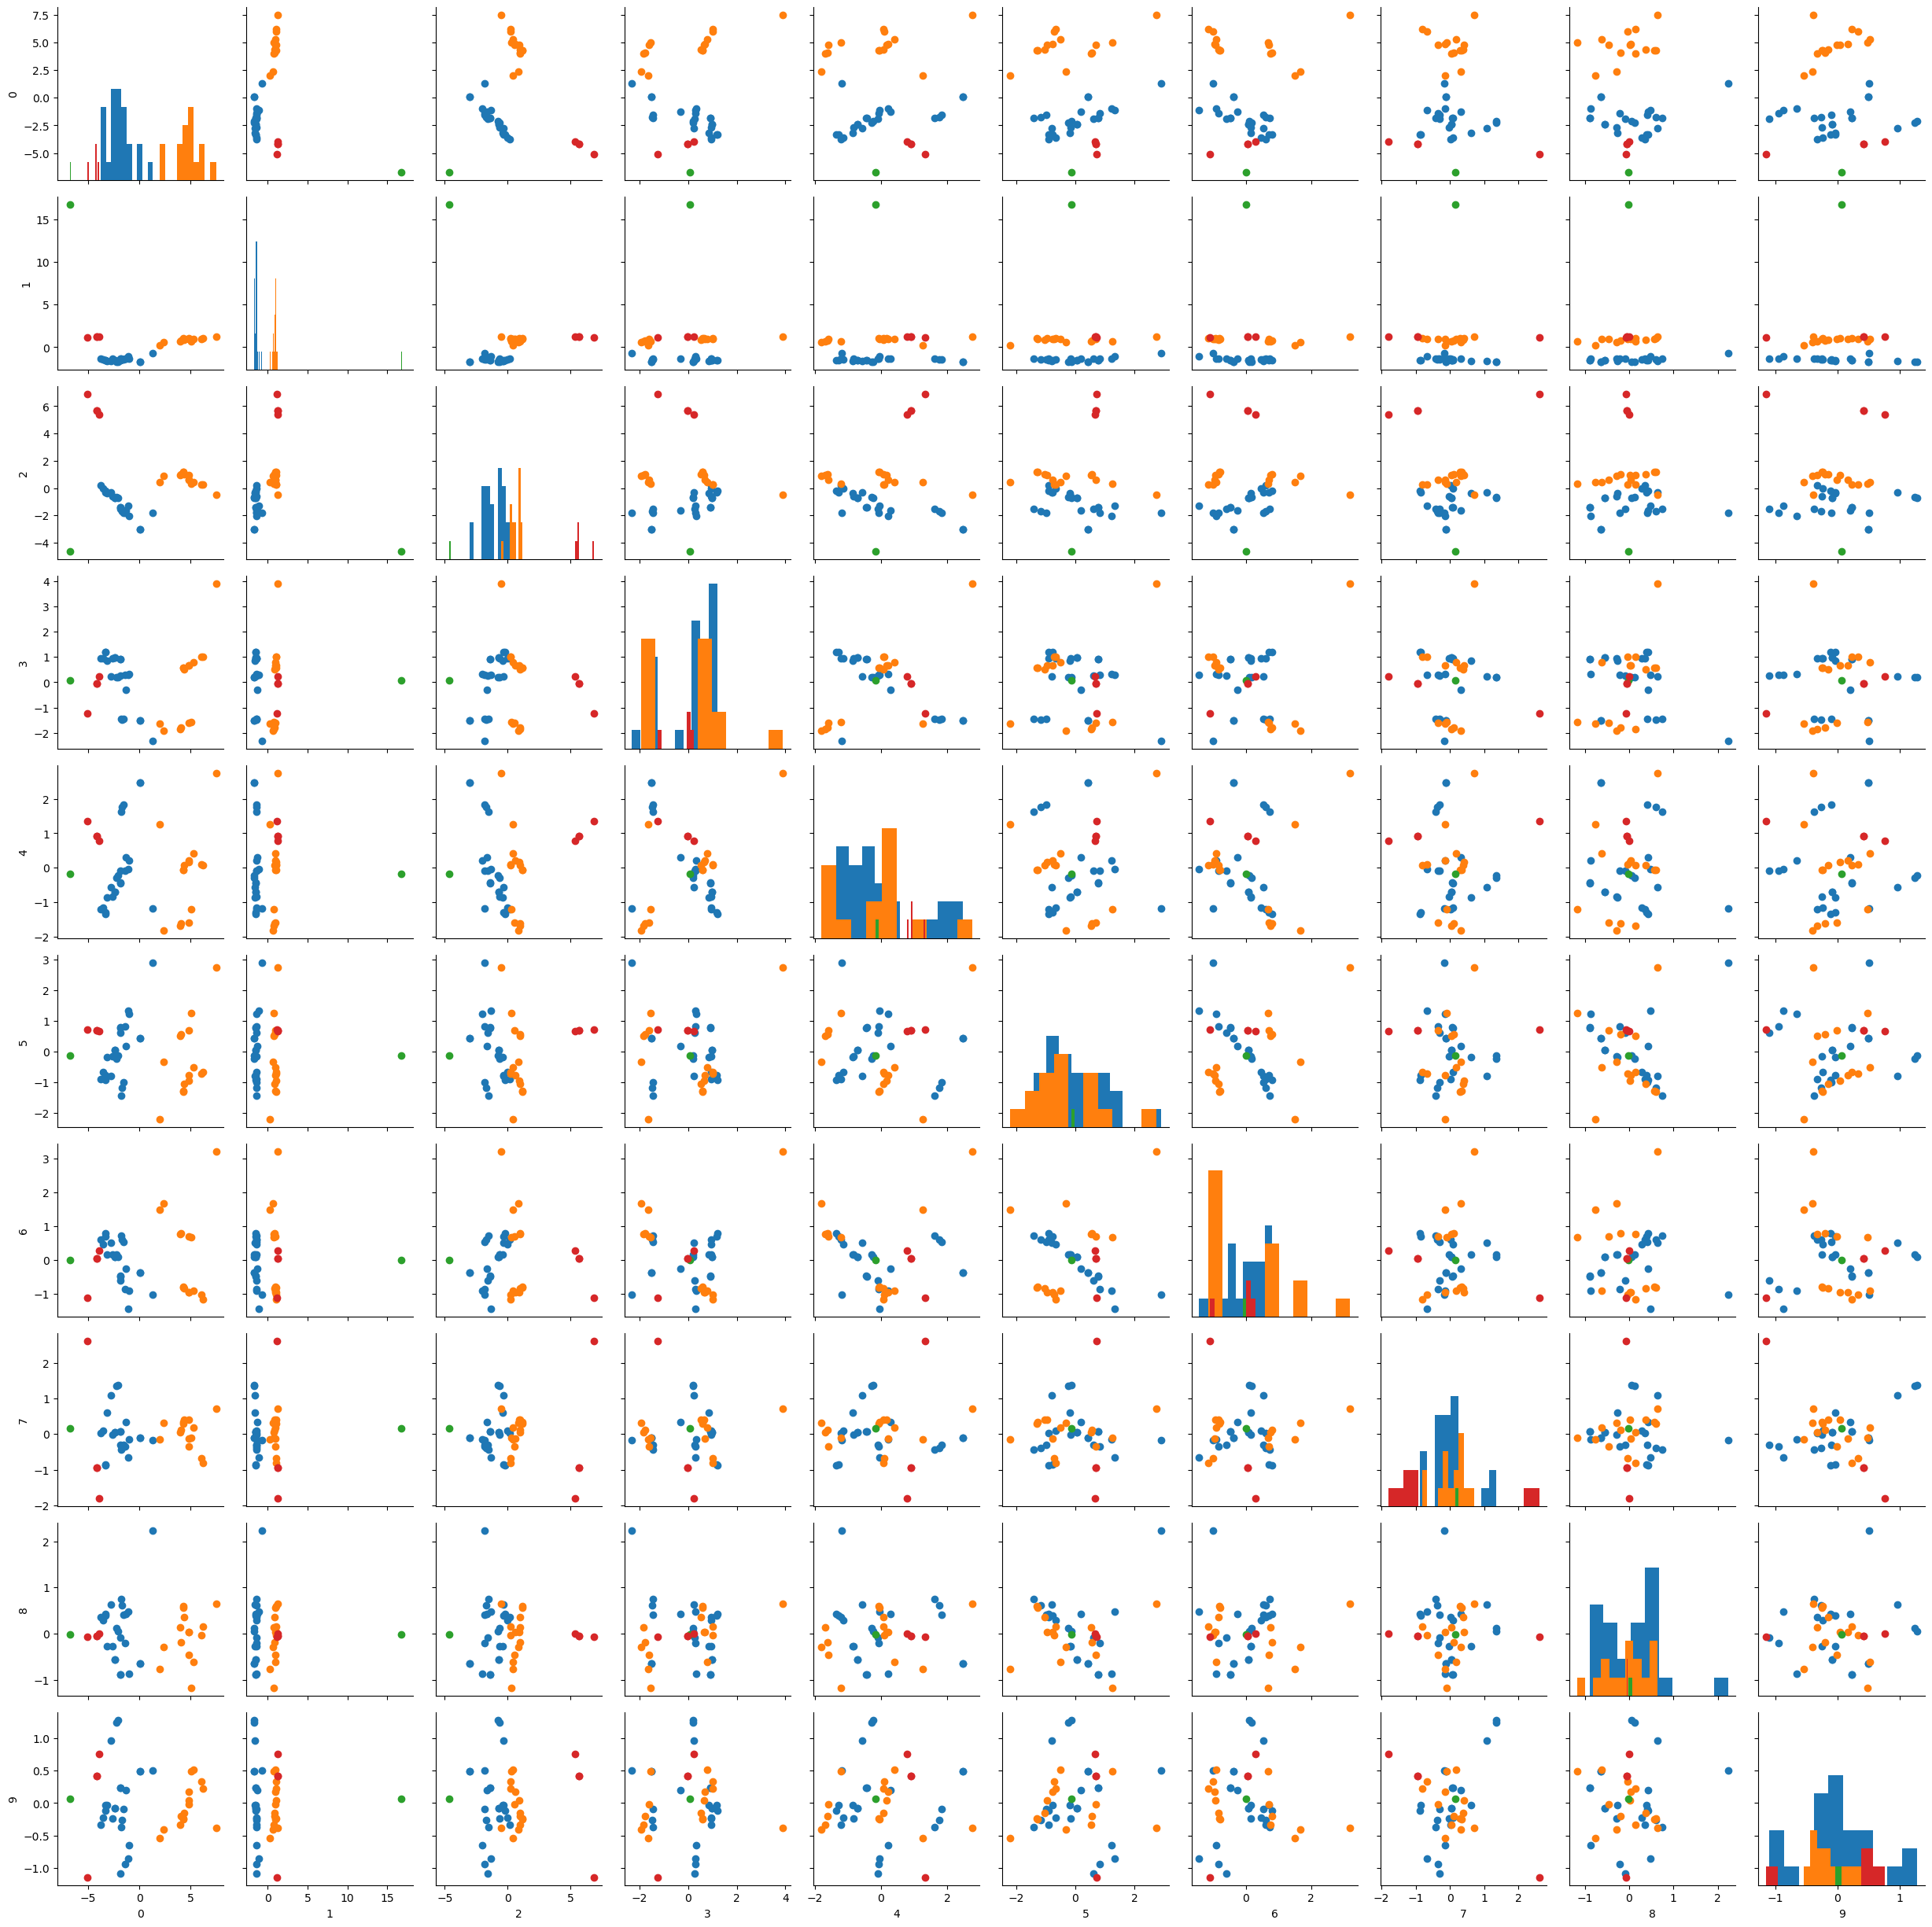

In [76]:
labels = kmeans.fit_predict(reduced_delta)

df = pd.DataFrame(reduced_delta)
df['c'] = labels
ax = sns.PairGrid(df, hue = 'c')
ax = ax.map_diag(plt.hist)
ax = ax.map_offdiag(plt.scatter)
ax

### Comparison between DBSCAN and K-means methods
For the reduced_delta dataset, we can see the presence of outliers in many of the feature pairings. K-means is sensitive to outliers and is likely to assign those outliers to a new cluster. Meanwhile, DBSCAN is not sensitive to outliers and rather just not assign these outlier points to any cluster. That's why k-means resulted in 4 clusters while DBSCAN has only 2 clusters. Depending on the clustering purpose, we might want to include outliers or not, so which method is better to use depends on that.

### K-Means on movemements.csv

In [77]:
movements=pd.read_csv("/Users/bianca/Documents/U of Chicago/Classes/Data Mining/Assignment-01-2024/Week_2_Data/movements.csv")
names = movements.columns[0]
movements_dropped = movements.drop(movements.columns[0], axis = 1)
movements_dropped

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
0,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
1,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
2,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
3,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
4,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,-0.709999,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998
5,0.450000,0.460001,0.180000,0.250000,-0.199999,-0.060000,-0.359998,0.190001,0.190001,-0.379999,...,0.240000,0.210000,-0.050000,-0.010000,-0.030000,-0.240000,0.050000,0.110000,-0.060000,-0.110000
6,0.180000,0.220001,0.040001,0.250000,-0.360001,-0.099999,0.570000,-0.139999,0.260002,-0.150002,...,0.220001,2.250000,0.470001,0.320000,-0.040001,-0.430000,-0.019997,-0.129998,0.330002,1.150001
7,0.730000,0.369999,-0.099999,-0.169999,0.030003,0.110001,-0.079998,0.140000,0.389999,-0.130001,...,0.209999,0.560002,0.069999,0.119999,0.050003,-0.459999,0.259998,-0.109999,0.090001,-0.110001
8,0.899997,0.700001,0.250000,0.369999,1.090000,3.179996,-0.769996,0.230004,-0.119998,-1.330002,...,0.209999,0.519996,1.029998,-0.020004,1.290001,-0.390000,1.209999,0.449997,-0.220001,0.159996
9,0.360000,0.909996,-0.290001,-0.059998,1.300003,0.510003,1.050003,0.529999,-0.360001,-0.540001,...,0.949997,1.520001,-0.320000,-0.500000,1.080002,0.280002,0.620003,0.359996,1.070003,1.050003


In [78]:
from sklearn.preprocessing import Normalizer

# Create a normalizer: normalizer
normalizer = Normalizer()

# Create a KMeans model with 10 clusters: kmeans
kmeans = KMeans(n_clusters=10)

# Make a pipeline chaining normalizer and kmeans: pipeline
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
pipeline.fit(movements_dropped)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10))])

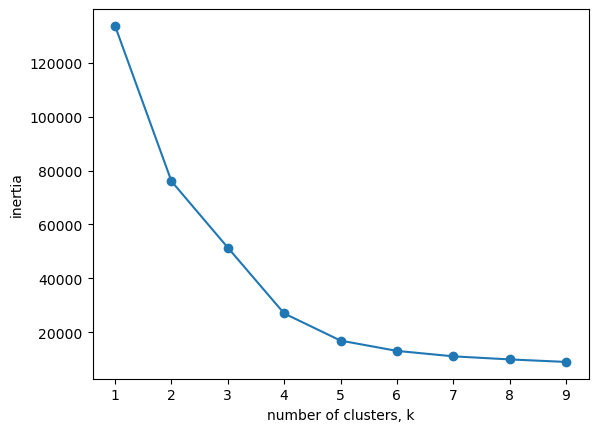

In [79]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(movements_dropped)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [80]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(movements_dropped)

KMeans(n_clusters=4)

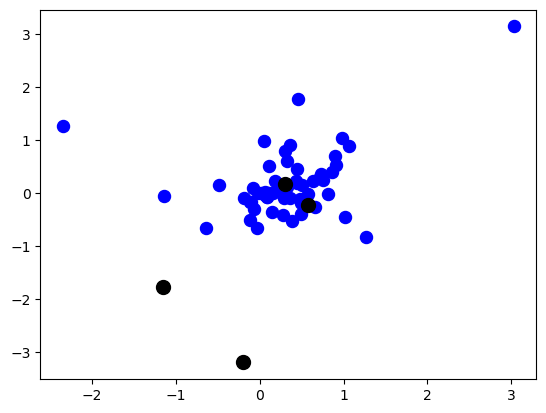

In [81]:
labels = kmeans.fit_predict(movements_dropped)

plt.scatter(movements_dropped.iloc[labels == 0, 0], movements_dropped.iloc[labels == 0, 1], s = 75, 
            c = 'blue', label = 'a')
plt.scatter(movements_dropped.iloc[labels == 1, 0], movements_dropped.iloc[labels == 1, 1], s = 75, 
            c = 'red', label = 'b')
plt.scatter(movements_dropped.iloc[labels == 2, 0], movements_dropped.iloc[labels == 2, 1], s = 75, 
            c = 'yellow', label = 'c')
plt.scatter(movements_dropped.iloc[labels == 3, 0], movements_dropped.iloc[labels == 3, 1], s = 75, 
            c = 'green', label = 'd')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'black', label = 'Centroide')
plt.show()

### DBSCAN on movemements.csv

In [82]:
movements_dropped = normalizer.fit_transform(movements_dropped)

In [83]:
dbsc = DBSCAN(eps = 1, min_samples = 15).fit(movements_dropped)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [84]:
labels

array([-1, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
       -1,  0,  0, -1,  0, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0, -1,
        0, -1,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0, -1, -1,  0, -1,  0,  0, -1])

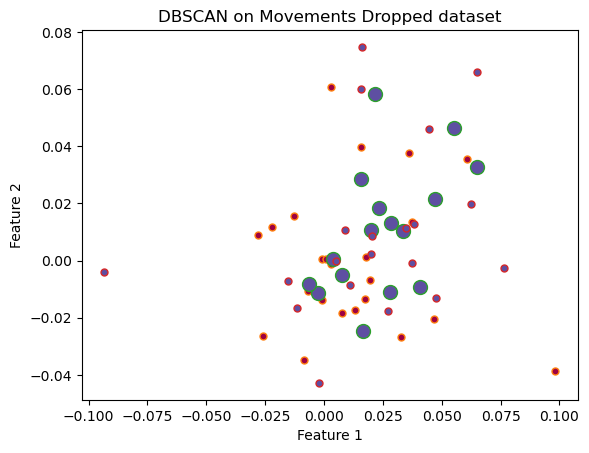

In [85]:
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = movements_dropped[class_member_mask & core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=color, markersize=10)

    xy2 = movements_dropped[class_member_mask & ~core_samples]
    plt.plot(xy2[:, 0], xy2[:, 1], 'o', markerfacecolor=color, markersize=5)

plt.title("DBSCAN on Movements Dropped dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Hierarchical on movements.csv

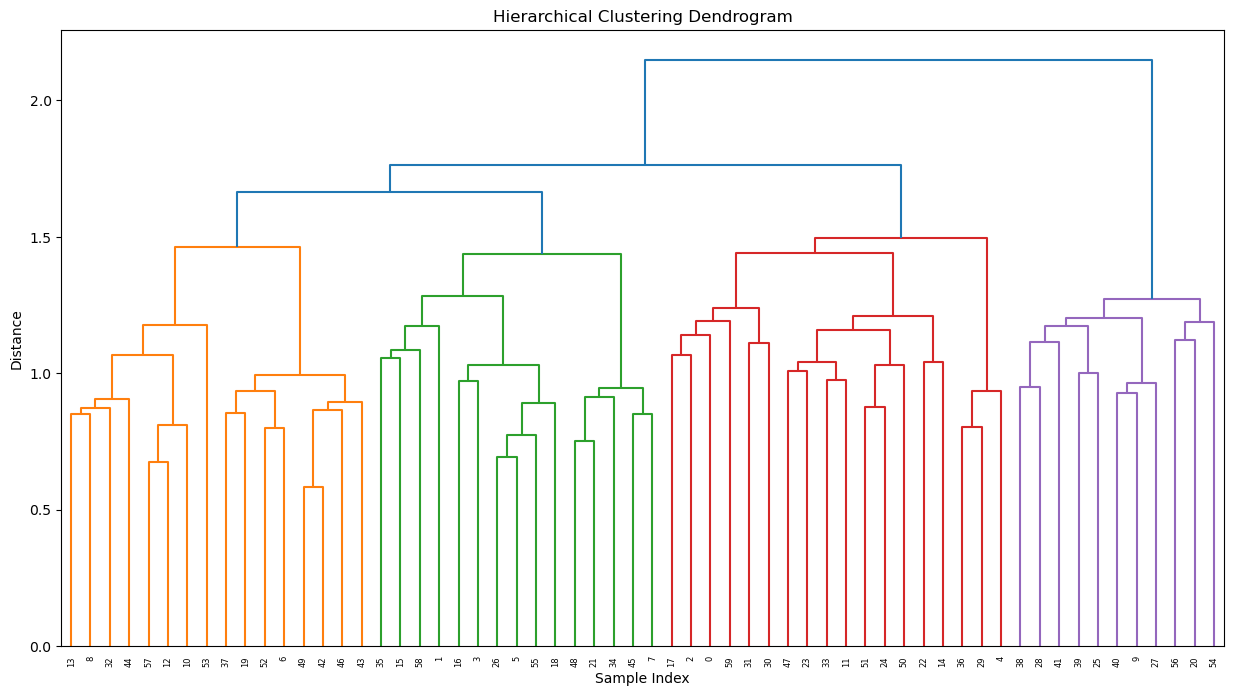

In [86]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering using linkage
linked = linkage(movements_dropped, 'ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

### Comparison between DBSCAN, k-means, and hierarchical clustering methods
With k-means clustering, the data is suggested to be clustered into 4 groups. However, we can only see 1 and this shows that k-means is not a good method to use for this dataset. We can see more clusters in DBSCAN, but it's also not very clear. Using the hierarchical clustering with Ward's linkage, we can see 4 distinct clusters and therefore we can say that hierarchical method is the best method for this dataset out of the 3 methods we used. This might be because the clusters are not spherical, similar in size or density, or the features might have complex relationship (such as temporal dependencies) that can't be captured as good by simple methods like k-means and DBSCAN.

### t-SNE Reduction

In [87]:
from sklearn.manifold import TSNE
delta = pd.read_csv('delta.csv', index_col='Aircraft')
delta = normalizer.fit_transform(delta)

In [88]:
delta

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00040559,
        0.00040559],
       [0.00612441, 0.01389041, 0.00378829, ..., 0.00031569, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00040178,
        0.00040178],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00061973,
        0.00061973],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00048229,
        0.00048229],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0010889 ,
        0.0010889 ]])

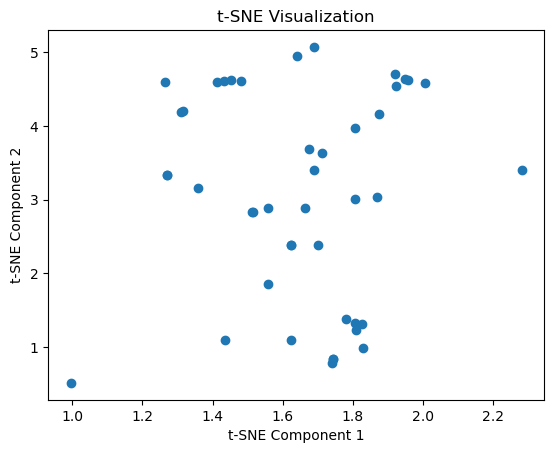

In [89]:
tsne = TSNE(n_components=2, random_state=42)

tsne_result = tsne.fit_transform(delta)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### Comparison between t-SNE and PCA
The PCA done in earlier sections resulted in 10 components left, while t-SNE resulted in 2 components. This shows that t-SNE might be prefereable for visualization because it is able to reduce the dimensions to less components than PCA. This means the data would be easier to use for 2D clustering methods. However, it'll be harder to interpret because it's not showing clear relationship between the features due to the low number of components. The t-SNE method is a non-linear method and PCA is a linear method. Choosing the better reduction method depends on the purpose or business case of clustering.

### Hiearchical Clustering
Applying Hiearchical Clustering to delta.csv and observe how physical features are being clustered in ealry leaves at the bottom.

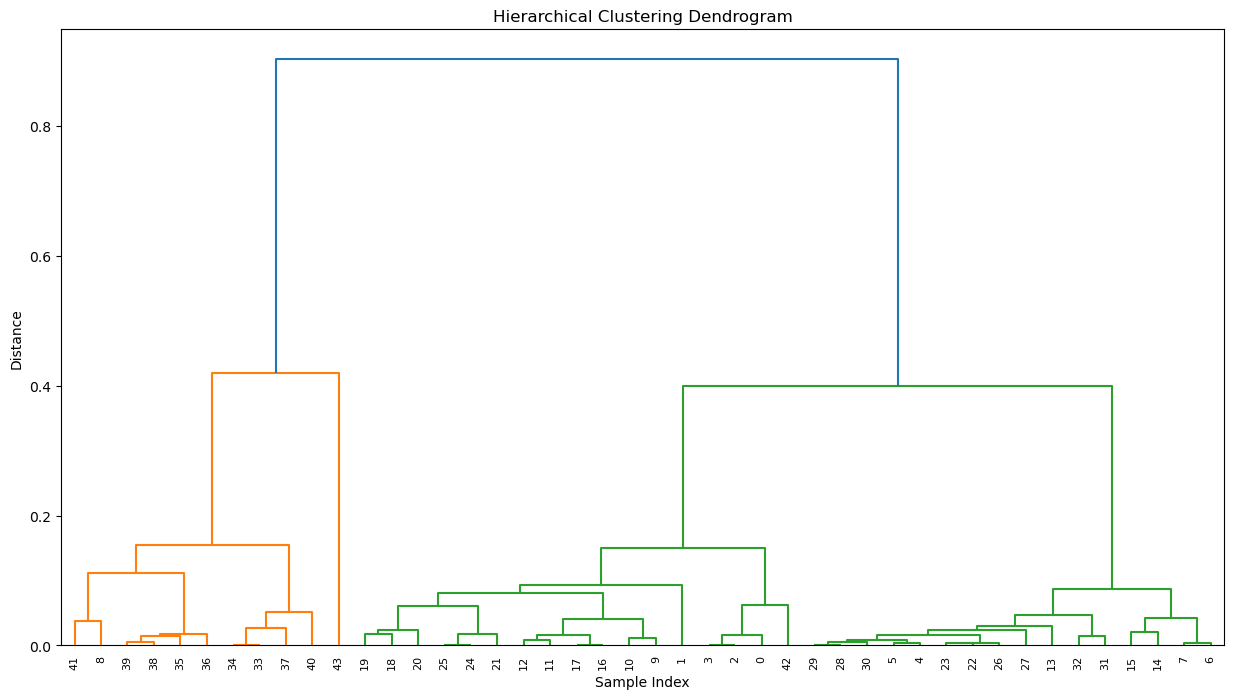

In [90]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(delta, 'ward')

plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

As we look further down the dendogram built using the ward's linkage, we can see that the early leaves have varying numbers of subclusters. This means the data have varying levels of heterogeneity, some data points are closer to each other compared to other subclusters or features.